<a href="https://colab.research.google.com/github/innosoft21/workspace/blob/main/tensorflow_python/2_1_cat_dog_kaggle_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cat vs. Dog Kaggle 데이터 이미지 분류

모양이 균일하도록 크기를 조정해야합니다.

고양이와 개의 예제 데이터 탐색, 
신경망을 구축하고 훈련하여 둘의 차이점을 인식합니다. 
교육 및 검증 정확도 평가.

In [2]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2021-04-30 05:41:30--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 74.125.137.128, 2607:f8b0:4023:c06::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   156MB/s    in 0.4s    

2021-04-30 05:41:31 (156 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



예제 데이터, 고양이와 강아지의 JPG 사진 2,000 장의 .zip 파일을 다운로드

 OS 라이브러리를 사용하여 운영 체제 라이브러리를 사용하여 파일 시스템에 대한 액세스 권한을 제공하고 데이터 압축을 풀 수있는 zipfile 라이브러리를 사용합니다.

In [3]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

다음 각 디렉토리를 정의 해 보겠습니다.

In [4]:
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


이제 cats및 dogs train디렉토리 에서 파일 이름이 어떻게 보이는지 보겠습니다

In [5]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.719.jpg', 'cat.486.jpg', 'cat.780.jpg', 'cat.355.jpg', 'cat.392.jpg', 'cat.566.jpg', 'cat.519.jpg', 'cat.91.jpg', 'cat.211.jpg', 'cat.772.jpg']
['dog.523.jpg', 'dog.709.jpg', 'dog.952.jpg', 'dog.761.jpg', 'dog.845.jpg', 'dog.884.jpg', 'dog.304.jpg', 'dog.642.jpg', 'dog.331.jpg', 'dog.183.jpg']


train및 validation디렉토리 에서 고양이와 강아지 이미지의 총 수를 알아 봅시다 .

In [6]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


고양이와 개 모두에 대해 1,000 개의 훈련 이미지와 500 개의 검증 이미지가 있습니다.

이제 고양이 및 강아지 데이터 세트가 어떻게 생겼는지 더 잘 이해하기 위해 몇 장의 사진을 살펴 보겠습니다. 

먼저 matplot 매개 변수를 구성합니다.

In [7]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

이제 8 개의 고양이 사진과 8 개의 강아지 사진을 표시합니다. 셀을 다시 실행하여 매번 새로운 배치를 볼 수 있습니다.

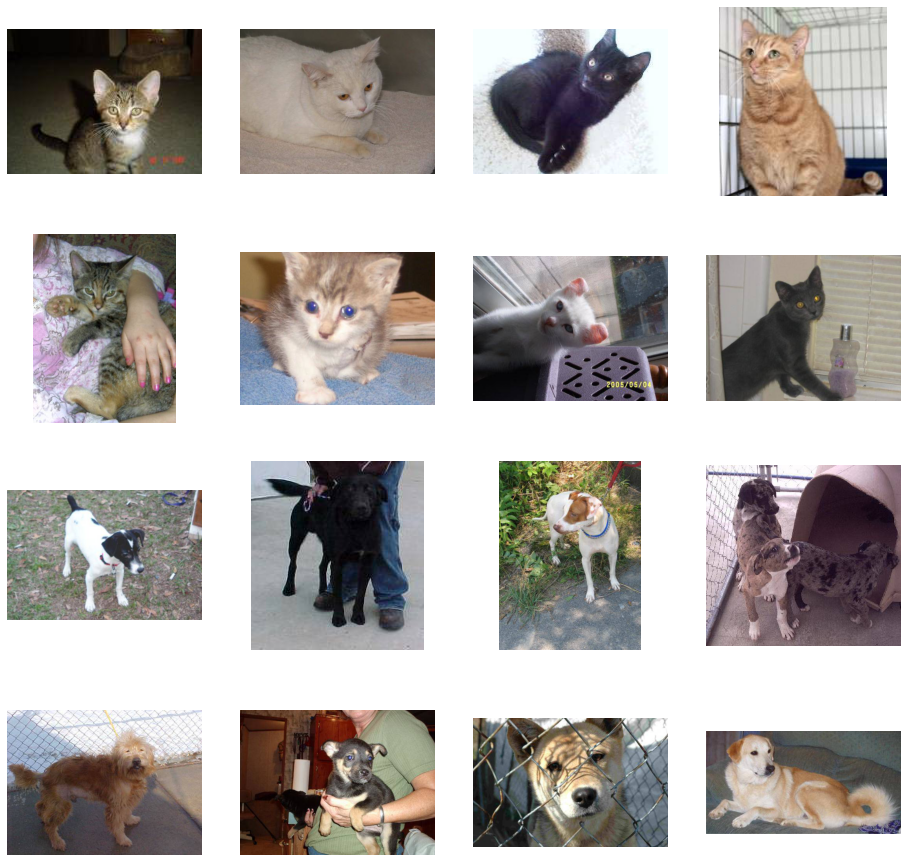

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [9]:
import tensorflow as tf

이전 예제에서는 이미지가 그레이 스케일로 28x28 (8 비트, 색상 심도 1 바이트)이기 때문에 28x28x1이었습니다. 이번에는 크기가 150x150이고 색 농도가 3 (24 비트, 3 바이트)입니다.

In [10]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

binary_crossentropy이진 분류 문제이고 최종 활성화가 시그 모이 드이기 때문에 손실로 모델을 훈련 할 것 입니다. 

rmsprop학습률이 0.001. 훈련 중에 분류 정확성을 모니터링하려고합니다.

이 경우 RMSprop 최적화 알고리즘을 사용하는 것이 확률 적 경사 하강 법 (SGD)보다 선호됩니다.

In [11]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

데이터 전처리

훈련 이미지 용 과 유효성 검사 ImageDataGenerator가 하나씩 있습니다. 

ImageDataGenerator는 150x150 크기의 이미지 20 개와 해당 레이블 (이진)의 배치를 생성합니다.

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


사용 가능한 모든 2,000 개 이미지에 대해 15 epochs를 학습하고 1,000 개의 테스트 이미지를 모두 검증 해 보겠습니다.

에포크 당 4 개의 값 (Loss, Accuracy, Validation Loss and Validation Accuracy)이 표시됩니다.

손실과 정확성은 훈련의 진행 상황을 나타내는 훌륭한 지표입니다. 

훈련 데이터의 분류를 추측 한 다음 알려진 레이블에 대해 측정하여 결과를 계산합니다. 

정확성은 정확한 추측의 일부입니다. 검증 정확도는 훈련에 사용되지 않은 데이터를 사용한 측정입니다. 예상대로 이것은 약간 낮을 것입니다. 

이 과정의 뒷부분에서 과적 합에 대한 섹션에서 이것이 발생하는 이유에 대해 알아 봅니다.

In [13]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=15,
                              validation_steps=50,
                              verbose=2)

Epoch 1/15
100/100 - 57s - loss: 0.9921 - accuracy: 0.5570 - val_loss: 0.6599 - val_accuracy: 0.5920
Epoch 2/15
100/100 - 56s - loss: 0.6506 - accuracy: 0.6360 - val_loss: 0.7561 - val_accuracy: 0.5530
Epoch 3/15
100/100 - 56s - loss: 0.5565 - accuracy: 0.7260 - val_loss: 0.6064 - val_accuracy: 0.6760
Epoch 4/15
100/100 - 56s - loss: 0.4728 - accuracy: 0.7765 - val_loss: 0.5645 - val_accuracy: 0.7250
Epoch 5/15
100/100 - 56s - loss: 0.3875 - accuracy: 0.8200 - val_loss: 0.7229 - val_accuracy: 0.7120
Epoch 6/15
100/100 - 55s - loss: 0.3097 - accuracy: 0.8690 - val_loss: 0.6757 - val_accuracy: 0.6820
Epoch 7/15
100/100 - 56s - loss: 0.2224 - accuracy: 0.9145 - val_loss: 0.8701 - val_accuracy: 0.7140
Epoch 8/15
100/100 - 56s - loss: 0.1621 - accuracy: 0.9430 - val_loss: 0.8637 - val_accuracy: 0.7270
Epoch 9/15
100/100 - 55s - loss: 0.1111 - accuracy: 0.9650 - val_loss: 1.2303 - val_accuracy: 0.7290
Epoch 10/15
100/100 - 56s - loss: 0.0890 - accuracy: 0.9720 - val_loss: 1.1611 - val_accura

하나 이상의 파일을 선택한 다음 업로드하고 모델을 통해 실행하여 개체가 개인 지 고양이인지를 표시 할 수 있습니다.

In [14]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0]>0:
    print(fn + " is a dog")
    
  else:
    print(fn + " is a cat")

중간 표현 시각화

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


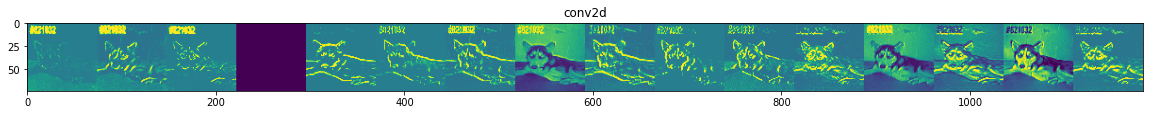

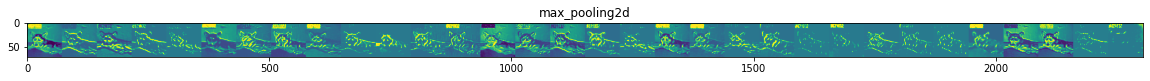

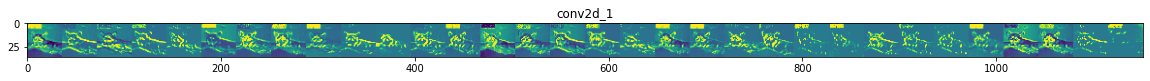

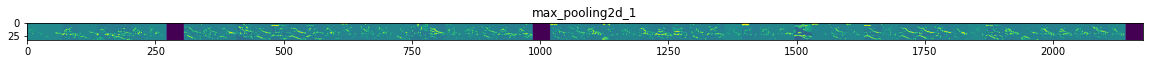

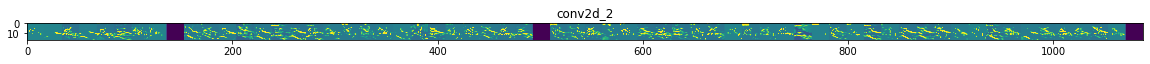

In [15]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

훈련 중에 수집 된 훈련 / 검증 정확도 및 손실을 플로팅 해 보겠습니다.

Text(0.5, 1.0, 'Training and validation loss')

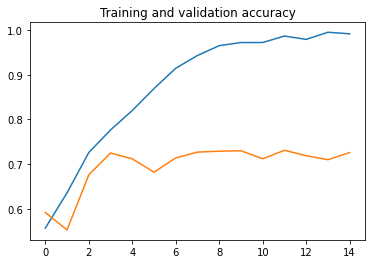

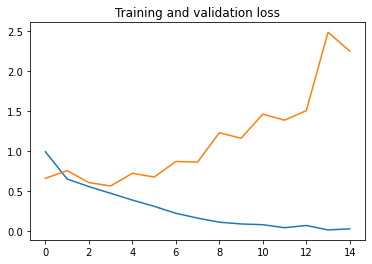

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

보시다시피, 우리는 패션에서 벗어난 것처럼 과적 합하고 있습니다. 

훈련 정확도 (파란색)는 100 % (!)에 가까워지고 검증 정확도 (녹색)는 70 %로 멈 춥니 다. 검증 손실은 단 5 세대 후에 최소값에 도달합니다.

훈련 예제 (2000)가 상대적으로 적기 때문에 과적 합이 가장 큰 관심사 여야합니다. 과적 합은 너무 적은 예제에 노출 된 모델이 새로운 데이터로 일반화되지 않는 패턴을 학습 할 때 발생합니다. 즉, 모델이 예측을 위해 관련없는 기능을 사용하기 시작할 때 발생합니다.